<a href="https://colab.research.google.com/github/shajarian/GNN/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
!pip install scikit-learn matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -o "/content/drive/My Drive/Semester 3/Big Data/HW3/1/Alzheimer.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  in

First thing is loading the MRI images and convert them into a format suitable for a GNN. GNNs typically operate on graph data, so each image should be converted into a graph. This could be done using methods like superpixel segmentation or by treating each pixel (or patches of pixels) as nodes in a graph.

In [ ]:
import os
for dirpath, dirnames, filenames in os.walk('/content/dataset'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in '/content/dataset'.
There are 2 directories and 0 images in '/content/dataset/Alzheimer_s Dataset'.
There are 4 directories and 0 images in '/content/dataset/Alzheimer_s Dataset/train'.
There are 0 directories and 717 images in '/content/dataset/Alzheimer_s Dataset/train/MildDemented'.
There are 0 directories and 52 images in '/content/dataset/Alzheimer_s Dataset/train/ModerateDemented'.
There are 0 directories and 2560 images in '/content/dataset/Alzheimer_s Dataset/train/NonDemented'.
There are 0 directories and 1792 images in '/content/dataset/Alzheimer_s Dataset/train/VeryMildDemented'.
There are 4 directories and 0 images in '/content/dataset/Alzheimer_s Dataset/test'.
There are 0 directories and 179 images in '/content/dataset/Alzheimer_s Dataset/test/MildDemented'.
There are 0 directories and 12 images in '/content/dataset/Alzheimer_s Dataset/test/ModerateDemented'.
There are 0 directories and 640 images in '/content/dataset/Alzheimer_s Da

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.datasets import TUDataset
from sklearn.metrics import roc_curve, auc

In [ ]:
class MRIDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, idx in self.classes.items():
            label_dir = os.path.join(self.root_dir, label)
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                image = Image.open(img_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                # Dummy implementation of image to graph conversion
                nodes = torch.randn((100, 3))  # Node features
                edge_index = torch.randint(0, 100, (2, 300))
                images.append(Data(x=nodes, edge_index=edge_index, y=torch.tensor(idx)))
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

In [ ]:
train_dataset = MRIDataset(root_dir='/content/dataset/Alzheimer_s Dataset/train', transform=transforms.ToTensor())
test_dataset = MRIDataset(root_dir='/content/dataset/Alzheimer_s Dataset/test', transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
from torch_geometric.nn import global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(3, 16)  # Assuming 3 features per node
        self.conv2 = GCNConv(16, 4)
        self.fc = torch.nn.Linear(4, 4)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch) # Use global mean pooling to aggregate node features into a single graph feature
        x = self.fc(x)  # Final fully connected layer
        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data in train_loader:
        data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # return total_loss / len(train_loader)
        preds = output.argmax(dim=1)
        correct += (preds == data.y).sum().item()
        total += data.y.size(0)
    accuracy = correct / total
    return total_loss / len(train_loader), accuracy

# Example of training loop
num_epochs = 5
train_losses = []
train_accuracies = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)  # Append accuracy to its list

    print(f'Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy * 100:.2f}%')

Epoch 1: Train Loss = 1.0581, Train Accuracy = 49.93%
Epoch 2: Train Loss = 1.0492, Train Accuracy = 49.99%
Epoch 3: Train Loss = 1.0380, Train Accuracy = 49.99%
Epoch 4: Train Loss = 1.0407, Train Accuracy = 48.92%
Epoch 5: Train Loss = 1.0384, Train Accuracy = 49.35%


In [ ]:
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            correct += (preds == data.y).sum().item()
            total += data.y.size(0)
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(data.y.cpu().numpy())  # Collect actual labels
    accuracy = correct / total
    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)
    return accuracy, all_preds, all_labels, fpr, tpr, roc_auc

# accuracy, predictions, labels = test(model, test_loader, device)
# print(f'Test Accuracy: {accuracy*100:.2f}%')
test_accuracy, predictions, labels, fpr, tpr, roc_auc = test(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Test Accuracy: 50.04%


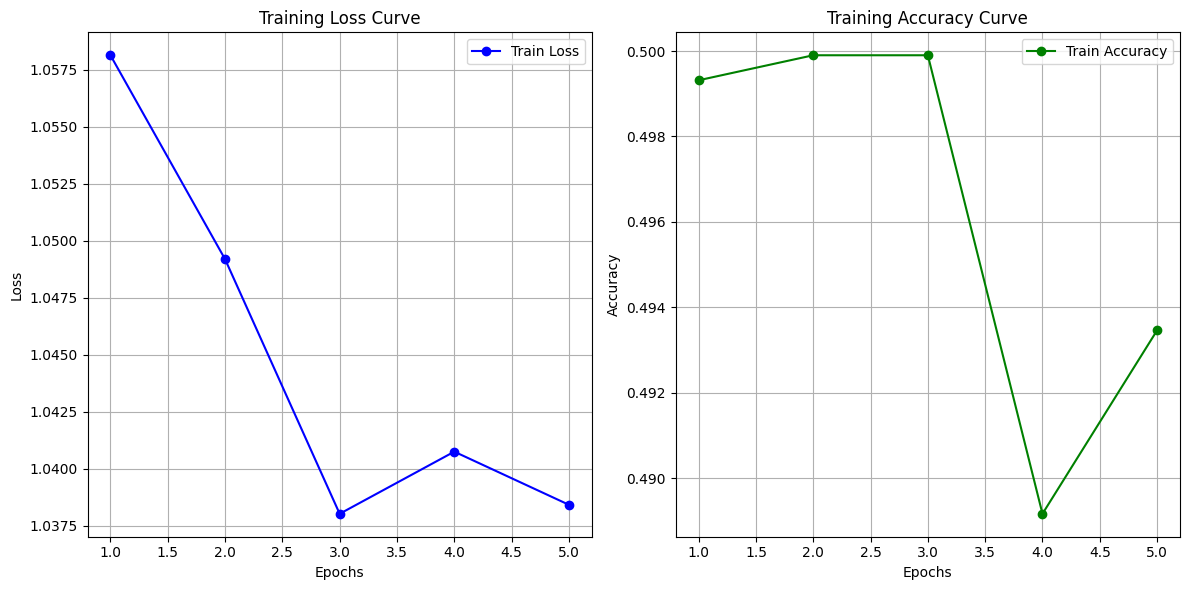

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='blue', label='Train Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', color='green', label='Train Accuracy')
plt.title('Training Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

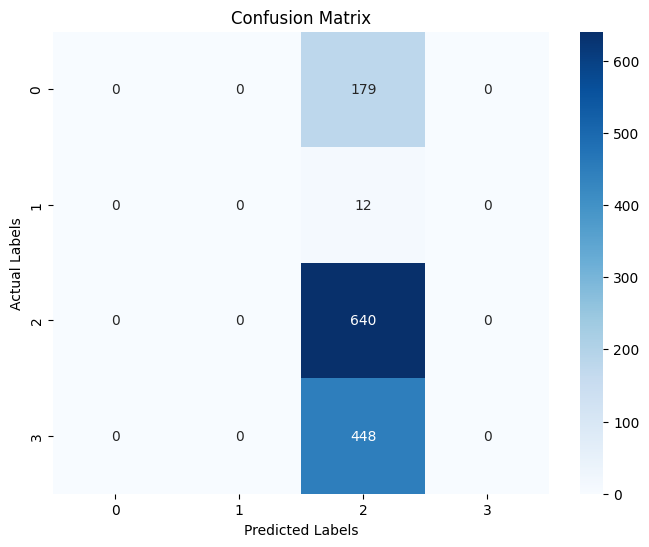

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

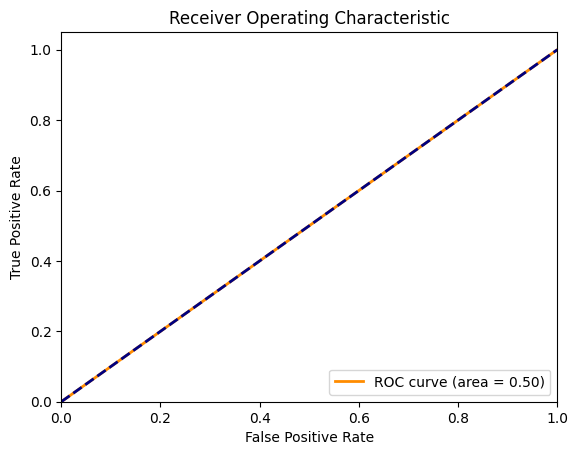

In [ ]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()